In [ ]:
## a useful function to generate a data list for further analysis
import os,json,sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from scipy import stats
import scipy.stats as st
import h5py
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file,findLongestConseqSubseq

#### Session 0.2: Load analysis methods in python dictionary form

In [3]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
#Put the folder of your Unity folder below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
#thisDataset ="D:/MatrexVR_grass1_Data/RunData"
thisDataset ="D:/MatrexVR_2024_Data/RunData"
#parameter name means independent variable in the experiment
variable_name='mu'
#variable_name='agent_speed'
#check trace in trial 115 from VR1_2024-11-16_155242_score_full, maybe there is a jump
analysis_window=analysis_methods.get("analysis_window")
monitor_fps=analysis_methods.get("monitor_fps")

In [ ]:
#methods to load hdf file save from other format
filename="D:/MatrexVR_2024_Data/RunData/20241116_155210/VR1_2024-11-16_155242_XY_full_test.h5"
Timestamp = {}
XY={}
Heading={}
with h5py.File(filename, "r") as f:
    for key in f.keys():
        #print(key)

        ds_arr = f[key]["TimeStamp"][:] # returns as a numpy array
        Timestamp[key] = ds_arr # appends the array in the dict under the key
        ds_arr = f[key]["XY1"][:] # returns as a numpy array
        XY[key]=ds_arr
        ds_arr = f[key]["Heading"][:] # returns as a numpy array
        Heading[key] =ds_arr

#df = pd.DataFrame.from_dict(dictionary)

#### Session 1.0: select animals based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [12]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        # database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8"
        #         #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8/edit?usp=sharing
        # url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name)
        animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values

    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

In [22]:
dir_list=dir_list[-32:]
vr_no=vr_no[-32:]

### Session 1.1: introduce helper functions to make plot and calculate speed

In [5]:
import matplotlib as mpl
from matplotlib import cm
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)
colormap_name = "viridis"

In [6]:
def calculate_speed(dif_x,dif_y,ts,number_frame_scene_changing=5):
    focal_distance_fbf=np.sqrt(np.sum([dif_x**2,dif_y**2],axis=0))
    focal_distance_fbf[0:number_frame_scene_changing+1]=np.nan##plus one to include the weird data from taking difference between 0 and some value
    instant_speed=focal_distance_fbf/np.diff(ts)
    return instant_speed

In [7]:
def unwrap_degree(angle_rad,number_frame_scene_changing):
    angle_rad[np.isnan(angle_rad)] = 0
    # angle_rad=np.unwrap(angle_rad)
    # angular_velocity=np.diff(np.unwrap(angle_rad))
    ang_deg = np.mod(np.rad2deg(angle_rad),360.) ## if converting the unit to degree
    angular_velocity=np.diff(np.unwrap(ang_deg,period=360))##if converting the unit to degree
    angle_rad[0:number_frame_scene_changing+1]=np.nan ##plus one to include the weird data from taking difference between 0 and some value
    angular_velocity[0:number_frame_scene_changing+1]=np.nan  ##plus one to include the weird data from taking difference between 0 and some value   
    return angle_rad,angular_velocity

In [8]:
def trajectory_analysis(df_XY):
    trajec_lim=150
    variables=np.sort(df_XY[df_XY['type']!='empty_trial']['mu'].unique(),axis = 0)
    fig, subplots = plt.subplots(
        nrows=1, ncols=variables.shape[0]+1, figsize=(20, 4), tight_layout=True
    )
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    #plt.rcParams['font.family'] = 'Helvetica'
    cmap = plt.get_cmap('viridis')
    for key, grp in df_XY.groupby('fname'):
        if grp['type'][0]=='empty_trial':
            subplot_title='ISI'
            subplots[0].scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            this_subplot=0
        else:
            for count,this_variable in enumerate(variables):
                if this_variable==grp['mu'][0]:
                    this_subplot=count+1
                    subplot_title=f'direction:{this_variable}'
                    subplots[this_subplot].scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
                else:
                    continue
        subplots[this_subplot].set(
        xlim=(-1*trajec_lim, trajec_lim),
        ylim=(-1*trajec_lim, trajec_lim),
        yticks=([-1*trajec_lim, 0, trajec_lim]),
        xticks=([-1*trajec_lim, 0, trajec_lim]),
        aspect=('equal'),
        title=subplot_title)
            # if grp['mu'][0]==0:
            #     ax2.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            # elif grp['mu'][0]==45:
            #     ax3.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            # elif grp['mu'][0]==315:
            #     ax4.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            # else:
            #     print("unexpected direction")
    # ax2.plot(df_agent.loc[df_agent['mu'] == 0]['X'].values,df_agent.loc[df_agent['mu'] == 0]['Y'].values,color='k')
    # ax3.plot(df_agent.loc[df_agent['mu'] == 45]['X'].values,df_agent.loc[df_agent['mu'] == 45]['Y'].values,color='k')
    # ax4.plot(df_agent.loc[df_agent['mu'] == 315]['X'].values,df_agent.loc[df_agent['mu'] == 315]['Y'].values,color='k')

    #plt.savefig(fig_name)
    plt.show()

In [9]:
def time_series_plot(target_distance,instant_speed,angles,analysis_window):
    fig, axes = plt.subplots(
        nrows=3, ncols=1, figsize=(9, 7), tight_layout=True
    )
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    cmap = plt.get_cmap('viridis')
    ax1, ax2, ax3= axes.flatten()
    ax1.set(
        title='Distance'
    )
    ax2.set(
        title='Instant Speed'
    )
    ax3.set(
        # yticks=[0,90,180],
        #ylim=(-np.pi-0.1, np.pi+0.1),
        # ylim=(-5, 185),
        title='angular deviation'
    )
    # ax3.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    # ax3.yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
    # ax3.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax1.plot(np.arange(target_distance.shape[0]),target_distance)
    ax2.plot(np.arange(instant_speed.shape[0]),instant_speed)
    ax3.plot(np.arange(angles.shape[0]),angles)
    plt.show()

### Section 2.0: Pool animal's response together according to some criteria (from none criteria to criteria that can define the follow behaviour)
Output1: a list 'follow_proportion_across_animals' showing the proportion of 'follow' time for each animal (across trials)

Output2: a list 'relative_pos_all_animals' showing relative position between virtual and focal locusts across time. 1st and 2nd columns shown relative x and y, 3rd columns shown virtual animal's moving direction. 4th column shown the timestamp

In [10]:
analysis_methods.update({"plotting_trajectory": False})

In [ ]:
trajec_lim=150
max_target_distance=50
extract_follow_epoches=True
relative_pos_all_animals=[]
trial_evaluation_across_animals=[]
follow_proportion_across_animals=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    if Path(this_dir).is_dir()==False:
        continue
    agent_pattern = f"VR{this_vr}*agent_full.h5"
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    found_result = find_file(Path(this_dir), agent_pattern)
    df_agent = pd.read_hdf(found_result)
    found_result = find_file(Path(this_dir), xy_pattern)
    df_XY = pd.read_hdf(found_result)
    test = np.where(df_XY["heading"].values == 0)[0]
    num_unfilled_gap=findLongestConseqSubseq(test,test.shape[0])
    if animal_id==0:
        largest_unfilled_gap=num_unfilled_gap
    elif num_unfilled_gap>largest_unfilled_gap:
        largest_unfilled_gap=num_unfilled_gap
    else:
        pass
    print(f"the length :{num_unfilled_gap} of unfilled gap in {found_result}")
    df_agent['this_vr']=this_vr
    df_agent['fname']=df_agent['fname'].astype(str) + '_' + df_agent['this_vr'].astype(str)   
    df_XY['this_vr']=this_vr
    df_XY['fname']=df_XY['fname'].astype(str) + '_' + df_XY['this_vr'].astype(str)
    if analysis_methods.get("plotting_trajectory"):
        trajectory_analysis(df_XY)
    dif_across_trials=[]
    follow_epochs_across_trials=np.ones((len(df_agent['fname'].unique()),1))
    total_epochs_across_trials=np.ones((len(df_agent['fname'].unique()),1))
    trial_evaluation_list=[]
    trial_id=0
    for key, grp in df_XY.groupby('fname'):
        if grp['type'][0]=='empty_trial':
            focal_xy=np.vstack((grp["X"].to_numpy(),grp["Y"].to_numpy()))
            dif_x=np.diff(focal_xy[0])
            dif_y=np.diff(focal_xy[1])
            #distance_from_centre=np.sqrt(np.sum([focal_xy[0]**2,focal_xy[1]**2],axis=0))
            ts=grp["ts"].to_numpy()
            instant_speed= calculate_speed(dif_x,dif_y,ts)
            focal_distance_ISI=instant_speed*np.diff(ts)
            heading_direction = grp["heading"].to_numpy()
            _,turn_degree_ISI=unwrap_degree(heading_direction,num_unfilled_gap)
            pre_stim_ISI=grp['duration'][0]
            continue
        else:
            #print(f"stimulus degree: {grp['mu'][0]}")
            focal_xy=np.vstack((grp["X"].to_numpy(),grp["Y"].to_numpy()))
            dif_x=np.diff(focal_xy[0])
            dif_y=np.diff(focal_xy[1])
            distance_from_centre=np.sqrt(np.sum([focal_xy[0]**2,focal_xy[1]**2],axis=0))
            ts=grp["ts"].to_numpy()
            instant_speed= calculate_speed(dif_x,dif_y,ts)
            focal_distance_fbf=instant_speed*np.diff(ts)
            heading_direction = grp["heading"].to_numpy()
            _,turn_degree_fbf=unwrap_degree(heading_direction,num_unfilled_gap)
            #angular_velocity=turn_degree_fbf/np.diff(ts)

            agent_xy=np.vstack((df_agent[df_agent['fname']==key]["X"].to_numpy(),df_agent[df_agent['fname']==key]["Y"].to_numpy()))
            agent_distance_fbf=np.sqrt(np.sum([np.diff(agent_xy)[0]**2,np.diff(agent_xy)[1]**2],axis=0))
            vector_dif=agent_xy-focal_xy
            theta = np.radians(grp['mu'][0]-360)  
            rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])# calculate the rotation matrix to align the agent to move along the same direction
            vector_dif_rotated=rot_matrix @ vector_dif
            target_distance=LA.norm(vector_dif, axis=0)
            dot_product=np.diag(np.matmul(np.transpose(np.diff(focal_xy)),np.diff(agent_xy)))
            angles = np.arccos(dot_product/focal_distance_fbf/agent_distance_fbf)
            angles_in_degree= angles*180/np.pi
            if analysis_methods.get("plotting_trajectory"):
                time_series_plot(target_distance,instant_speed,angles_in_degree,analysis_window)

            follow_sercan=np.logical_and(target_distance[1:]<max_target_distance, instant_speed>1,angles_in_degree<10)
            if extract_follow_epoches:
                epochs_of_interest=follow_sercan
            else:
                epochs_of_interest=np.ones((instant_speed.shape[0]))==1.0#created a all-true array
            

            vector_dif_rotated=vector_dif_rotated[:,1:]
            degree_in_the_trial=np.repeat(grp['mu'][0],np.transpose(grp['ts'].values).shape[0])
            degree_time=np.vstack((degree_in_the_trial,grp['ts'].values))
            degree_time=degree_time[:,1:]
            follow_wrap=np.concat((vector_dif_rotated[:,epochs_of_interest],degree_time[:,epochs_of_interest]))
            follow_pd=pd.DataFrame(np.transpose(follow_wrap))
            follow_pd.insert(0, 'type',np.repeat(grp['type'][0],follow_pd.shape[0]))
            dif_across_trials.append(follow_pd)
            df_summary = pd.DataFrame(
                {
                    "trial_id": [trial_id],
                    "mu": [grp['mu'][0]],
                    "polar_angle": [grp['polar_angle'][0]],
                    "this_vr": [grp['this_vr'][0]],
                    "num_follow_epochs": [sum(follow_sercan)],
                    "number_frames": [grp.shape[0]-1],
                    "travel_distance": [np.nansum(focal_distance_fbf)],
                    "turning_distance": [np.nansum(abs(turn_degree_fbf))],
                    "travel_distance_ISI": [np.nansum(focal_distance_ISI)],
                    "turning_distance_ISI": [np.nansum(abs(turn_degree_ISI))],
                    "duration": [grp['duration'][0]],
                    "duration_ISI": [pre_stim_ISI],
                    "temperature": [grp['temperature'][0]],
                    "humidity": [grp['humidity'][0]],
                    "object":[grp['type'][0]]
                }
            )
            trial_evaluation_list.append(df_summary)
            trial_id=trial_id+1
    tmp=pd.concat(dif_across_trials)
    if tmp.shape[1]==2:
        tmp.columns = ['x', 'y']
    elif tmp.shape[1]==4:
        tmp.columns = ['x', 'y','degree','ts']
    elif tmp.shape[1]==5:
        tmp.columns = ['type','x', 'y','degree','ts']
        
    relative_pos_all_animals.append(tmp)
    trial_evaluation=pd.concat(trial_evaluation_list)
    trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
    trial_evaluation_across_animals.append(trial_evaluation)
    animal_id=animal_id+1
analysis_methods['largest_unfilled_gap']= largest_unfilled_gap

In [57]:
all_evaluation=pd.concat(trial_evaluation_across_animals)
##for grass background
fair_follower_threshold=0.1667
good_follower_threshold=0.3
##for blackground
# fair_follower_threshold=0.05
# good_follower_threshold=0.25

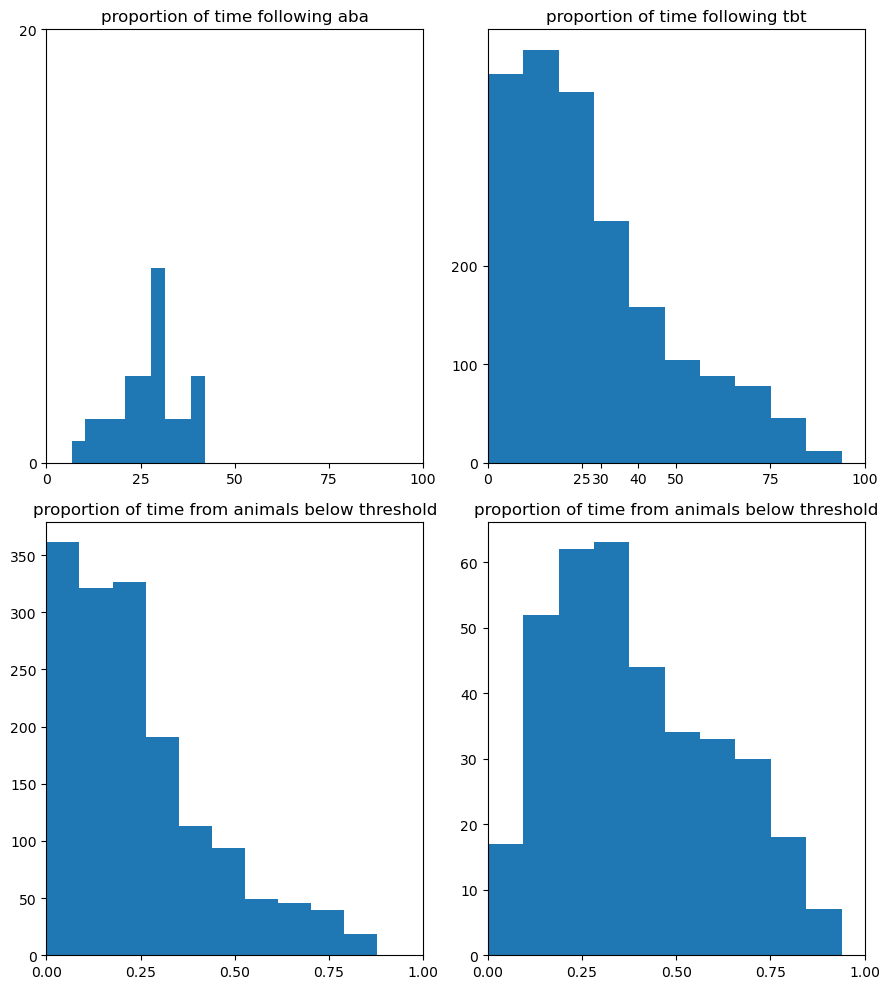

In [26]:
#1D histogram to show the frequency of following response
fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2, ax3, ax4 = axes.flatten()
ax1.hist(all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum())
ax1.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,1),yticks=[0,20],ylim=(0,20),title='proportion of time following aba')
ax2.hist(all_evaluation['num_follow_epochs']/all_evaluation['number_frames'])
ax2.set(xticks=[0,0.25,0.3,0.4,0.5,0.75,1],xticklabels=(['0', '25','30','40', '50', '75', '100']),xlim=(0,1),yticks=[0,100,200],title='proportion of time following tbt')
follower_of_interest=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()<good_follower_threshold
rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
ax3.hist(all_evaluation[rows_of_follower.values]['num_follow_epochs']/all_evaluation[rows_of_follower.values]['number_frames'])
ax3.set(xticks=[0,0.25,0.5,0.75,1],xlim=(0,1),title='proportion of time from animals below threshold')
follower_of_interest=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()>good_follower_threshold
rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
ax4.hist(all_evaluation[rows_of_follower.values]['num_follow_epochs']/all_evaluation[rows_of_follower.values]['number_frames'])
ax4.set(xticks=[0,0.25,0.5,0.75,1],xlim=(0,1),title='proportion of time from animals below threshold')
plt.show()

In [ ]:
##plot the relationship between travel distance and proportion of following time
glocust_list=[]
exp_agent_list=[]
fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2, ax3, ax4 = axes.flatten()
ax1.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,1))
ax2.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,1))
for keys, this_data in all_evaluation.groupby(['animal_id']):
    p_follow=this_data['num_follow_epochs'].sum()/this_data['number_frames'].sum()
    # if p_follow>good_follower_threshold:
    #     color='r'
    # elif (p_follow>fair_follower_threshold) and (p_follow<good_follower_threshold):
    #     color='b'
    # else:
    #     color='k'
    if p_follow>good_follower_threshold:
        pass
    elif (p_follow>fair_follower_threshold) and (p_follow<good_follower_threshold):
        pass
    else:
        continue
    ax1.scatter(this_data['num_follow_epochs'].sum()/this_data['number_frames'].sum(),this_data['travel_distance'].sum(),c=color,s=8)
    ax3.scatter(this_data['num_follow_epochs'].sum()/this_data['number_frames'].sum(),this_data['turning_distance'].sum(),c=color,s=8)
    for this_object in this_data['object'].unique():
        these_num_follow_epochs=this_data['num_follow_epochs'][this_data['object']==this_object]
        these_num_frames=this_data['number_frames'][this_data['object']==this_object]
        these_travel_distance=this_data['travel_distance'][this_data['object']==this_object]
        these_turning_distance=this_data['turning_distance'][this_data['object']==this_object]
        if this_object=='mov_glocust':
            # ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,c=color,s=8)
            # ax4.scatter(these_num_follow_epochs/these_num_frames,these_turning_distance,c=color,s=8)
            ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,c='b',s=8)
            ax4.scatter(these_num_follow_epochs/these_num_frames,these_turning_distance,c='b',s=8)
            follow_time_ratio_tbt=these_num_follow_epochs/these_num_frames
            glocust_list.append(follow_time_ratio_tbt.values)
        else:
            # ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,edgecolors=color,marker='o', facecolors='none',s=8)
            # ax4.scatter(these_num_follow_epochs/these_num_frames,these_turning_distance,edgecolors=color,marker='o', facecolors='none',s=8)
            ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,c='r',s=8)
            ax4.scatter(these_num_follow_epochs/these_num_frames,these_turning_distance,c='r',s=8)
            follow_time_ratio_tbt=these_num_follow_epochs/these_num_frames
            exp_agent_list.append(follow_time_ratio_tbt.values)
plt.show()

In [110]:
def summarise_as_csv(input_list,agent_type='glocust'):
    df=pd.DataFrame(np.hstack(input_list))
    df.insert(0, 'agent_type', np.repeat(agent_type,df.shape[0]).tolist())
    df.insert(0, 'ID', np.repeat(np.arange(len(input_list)),int(df.shape[0]/len(input_list))).tolist())
    df.to_csv(f'{agent_type}.csv')

In [111]:
summarise_as_csv(exp_agent_list,'exp_agent')

#### Section 2.1: Using 1D histogram to plot proportion of time and 2D histogram to plot relative position

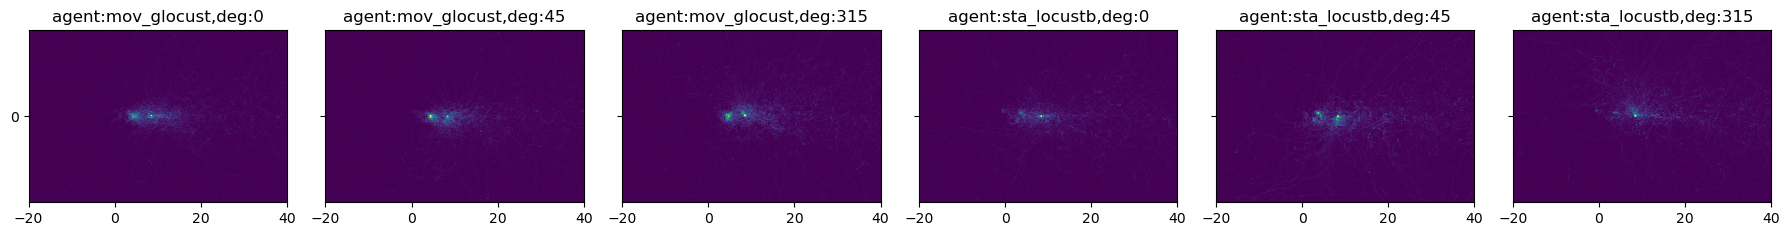

In [32]:
all_trials=pd.concat(relative_pos_all_animals)
fig, axes = plt.subplots(nrows=1, ncols=len(all_trials["type"].unique())*len(all_trials["degree"].unique()),figsize=(18, 6),tight_layout=True,sharex=True, sharey=True)
if extract_follow_epoches:
    xlimit=(-20,40)
    ylimit=(-20,20)
else:
    xlimit=(-20,100)
    ylimit=(-45,45)

i=0
for keys, grp in all_trials.groupby(['type','degree']):
        axes[i].hist2d(grp['x'].values,grp['y'].values,bins=400)
        axes[i].set(
        yticks=[-40,0,40],
        xticks=[-20,0,20,40],
        xlim=xlimit,ylim=ylimit,title=f'agent:{keys[0]},deg:{int(keys[1])}',adjustable='box', aspect='equal')
        i=i+1
plt.show()

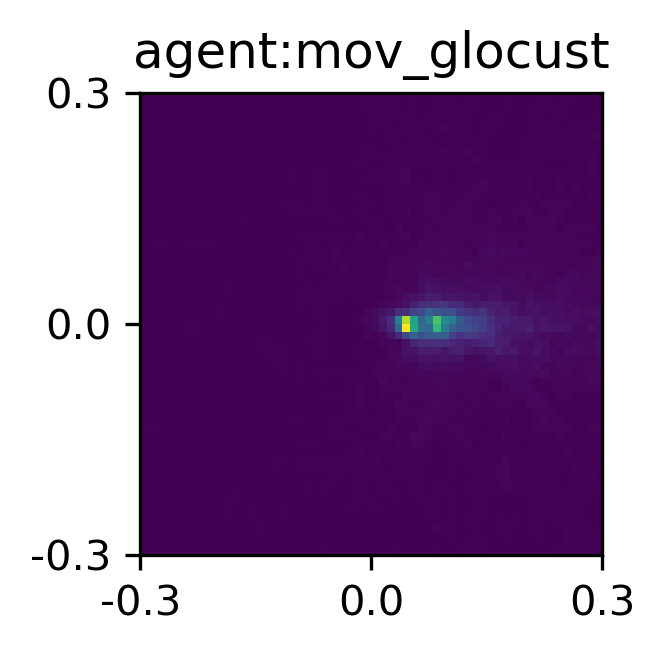

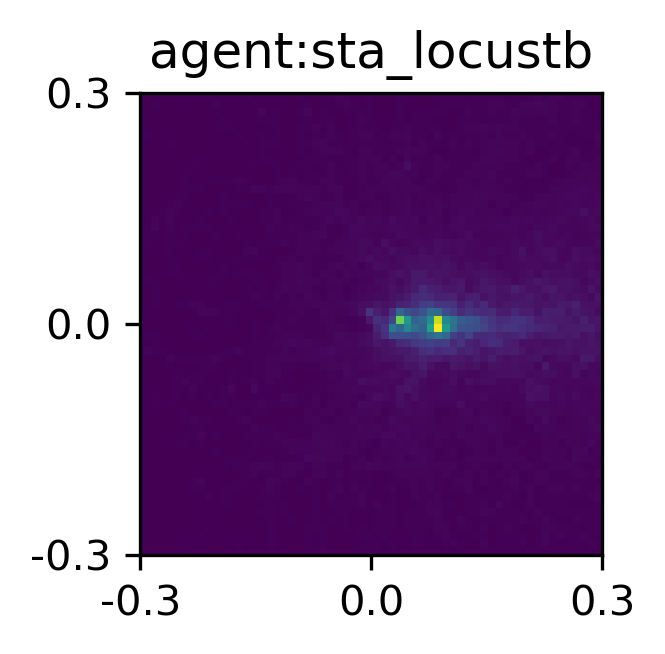

In [34]:
##plot potential follow response in 2D histogram
xlimit=(-30,30)
ylimit=(-30,30)
all_trials=pd.concat(relative_pos_all_animals)
for keys, grp in all_trials.groupby(['type']):
    fig, ax = plt.subplots(dpi=300, figsize=(2,2))
    ax.hist2d(grp['x'].values,grp['y'].values,bins=100)
    ax.set(adjustable='box', aspect='equal')
    ax.set(
        yticks=[-30,0.0,30],
        xticks=[-30,0.0,30],
        xticklabels=(['-0.3', '0.0', '0.3']),
        yticklabels=(['-0.3', '0.0', '0.3']),
        xlim=xlimit,ylim=ylimit,title=f'agent:{keys[0]}')
# fig, ax = plt.subplots(dpi=300, figsize=(2,2))
# sns.histplot(all_trials,x='x',y='y')
plt.show()

#### Section 2.2: save data into Mat file if needed

In [ ]:
##save the raw data into mat file for matlab
from scipy.io import savemat
all_raw=pd.concat(relative_pos_all_animals)
#all_raw['trial_id']=all_raw['trial_id'].astype(int)
data_dict = {name: col.values for name, col in all_raw.items()}
summary_file_name = Path(thisDataset) /"time_series_curated.mat"
savemat(summary_file_name, data_dict)

### Section 3.0, analysis walking behavours before and after the presence of stimulus

In [35]:
def fix_data_type(all_trials):

    all_trials['id'] = all_trials['id'].astype(int)
    all_trials['mu'] = all_trials['mu'].astype(int)
    all_trials['velocity'] = all_trials['velocity'].astype(float)
    all_trials['omega'] = all_trials['omega'].astype(float)
    all_trials['normalised_v'] = all_trials['normalised_v'].astype(float)
    all_trials['normalised_omega'] = all_trials['normalised_omega'].astype(float)
    if 'density' in all_trials.columns:
        all_trials['density'] = all_trials['density'].astype(int)
    return all_trials

In [ ]:
trajec_lim=150
good_follower_only=False
duration_for_baseline=3
align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
dif_across_animals=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    if Path(this_dir).is_dir()==False:
        continue
    agent_pattern = f"VR{this_vr}*agent_full.h5"
    found_result = find_file(Path(this_dir), agent_pattern)
    if found_result is not None:
        df_agent = pd.read_hdf(found_result)
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    found_result = find_file(Path(this_dir), xy_pattern)
    if found_result is None:
        continue
    df_XY = pd.read_hdf(found_result)
    df_XY['this_vr']=this_vr
    df_XY['fname']=df_XY['fname'].astype(str) + '_' + df_XY['this_vr'].astype(str)
    test = np.where(df_XY["heading"].values == 0)[0]
    num_unfilled_gap=findLongestConseqSubseq(test,test.shape[0])
    if animal_id==0:
        largest_unfilled_gap=num_unfilled_gap
    elif num_unfilled_gap>largest_unfilled_gap:
        largest_unfilled_gap=num_unfilled_gap
    else:
        pass
    print(f"the length :{num_unfilled_gap} of unfilled gap in {found_result}")
    #trajectory_analysis(df_XY)
    dif_across_trials=[]
    if 'basedline_v' in locals():
        del basedline_v
    trial_id=0
    for key, grp in df_XY.groupby('fname'):
        focal_xy=np.vstack((grp["X"].to_numpy(),grp["Y"].to_numpy()))
        distance_from_centre=np.sqrt(np.sum([focal_xy[0]**2,focal_xy[1]**2],axis=0))
        ts=grp["ts"].to_numpy()
        dif_x=np.diff(focal_xy[0])
        dif_y=np.diff(focal_xy[1])
        instant_speed=calculate_speed(dif_x,dif_y,ts)
        angle_rad = grp["heading"].to_numpy()
        _,angular_speed=unwrap_degree(angle_rad,num_unfilled_gap)

        if 'type' in df_XY.columns:
            if align_with_isi_onset:
                if grp['type'][0]=='empty_trial':
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
                else:
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]
            else:
                if grp['type'][0]=='empty_trial':
                    print('ISI now')
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]
                    basedline_v=np.mean(v_of_interest[-duration_for_baseline*monitor_fps:])
                    normalised_v=np.repeat(np.nan,v_of_interest.shape[0])
                    basedline_w=np.mean(w_of_interest[-duration_for_baseline*monitor_fps:])
                    normalised_w=np.repeat(np.nan,w_of_interest.shape[0])

                else:
                    print('stim now')
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
                    if 'basedline_v' in locals():
                        normalised_v=v_of_interest/basedline_v
                    else:
                        normalised_v=np.repeat(np.nan,v_of_interest.shape[0])
                    if 'basedline_w' in locals():
                        normalised_w=w_of_interest/basedline_w
                    else:
                        normalised_w=np.repeat(np.nan,w_of_interest.shape[0])

        else:
            if align_with_isi_onset:
                if grp['density'][0]==0.0:
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
                    if 'basedline_v' in locals():
                        normalised_v=v_of_interest/basedline_v
                    else:
                        normalised_v=np.repeat(np.nan,v_of_interest.shape[0])
                    if 'basedline_w' in locals():
                        normalised_w=w_of_interest/basedline_w
                    else:
                        normalised_w=np.repeat(np.nan,w_of_interest.shape[0])
                else:
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]
                    basedline_v=np.mean(v_of_interest[-duration_for_baseline*monitor_fps:])
                    normalised_v=np.repeat(np.nan,v_of_interest.shape[0])
                    basedline_w=np.mean(w_of_interest[-duration_for_baseline*monitor_fps:])
                    normalised_w=np.repeat(np.nan,w_of_interest.shape[0])

            else:
                if grp['density'][0]==0.0:
                    print('ISI now')
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]

                else:
                    print('Stim now')
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]


        if 'type' in df_XY.columns:
            con_matrex=(d_of_interest,v_of_interest,w_of_interest,normalised_v,normalised_w,np.repeat(trial_id,v_of_interest.shape[0]),np.repeat(grp['mu'][0],v_of_interest.shape[0]),np.repeat(grp['type'][0],v_of_interest.shape[0]))
        else:
            con_matrex=(d_of_interest,v_of_interest,w_of_interest,normalised_v,normalised_w,np.repeat(trial_id,v_of_interest.shape[0]),np.repeat(grp['mu'][0],v_of_interest.shape[0]),np.repeat(grp['density'][0],v_of_interest.shape[0]))
        raw_data=np.vstack(con_matrex)
        dif_across_trials.append(pd.DataFrame(np.transpose(raw_data)))
        trial_id += 1
    tmp=pd.concat(dif_across_trials)
    if 'type' in df_XY.columns:
        tmp.columns = ['distance_from_centre', 'velocity','omega','normalised_v','normalised_omega','id','mu','object']
    else:
        tmp.columns = ['distance_from_centre', 'velocity','omega','normalised_v','normalised_omega','id','mu','density']
    tmp.insert(0, 'animal_id', np.repeat(animal_id,tmp.shape[0]))
    dif_across_animals.append(tmp)
    animal_id += 1
analysis_methods['largest_unfilled_gap']= largest_unfilled_gap

In [37]:
if type(dif_across_animals)==list:
    all_trials=pd.concat(dif_across_animals)
    all_trials=fix_data_type(all_trials)
else:
    all_trials=fix_data_type(dif_across_animals)

In [38]:
def check_baseline_distribution(all_trials,analysis_methods,metrics_name='velocity',duration_for_baseline=3):
    align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
    these_baselines=[]
    for keys, this_data in all_trials.groupby(['animal_id','id']):
        #print(this_data['object'][1])
        if align_with_isi_onset:
            if this_data['object'][1]!='empty_trial':
            #if keys[1]%2==0:#for the Swarm scene to only use stim trials to get the baseline
                this_speed=this_data[metrics_name].values
                #print(this_speed)
                these_baselines.append(np.mean(this_speed[-duration_for_baseline*monitor_fps:]))
        
        else:
            if this_data['object'][1]=='empty_trial':
            #if keys[1]%2!=0:#for the Swarm scene to only use ISI trials
                this_speed=this_data[metrics_name].values
                these_baselines.append(np.mean(this_speed[-duration_for_baseline*monitor_fps:]))
    fig, axes = plt.subplots(
        nrows=1, ncols=1, figsize=(9,9), tight_layout=True
    )
    axes.hist(np.vstack(these_baselines),bins=500)
    if metrics_name=='velocity':
        axes.set(xlim=(0,2),ylim=(0, 60))
    else:
        #axes.set(xlim=(-0.001,0.001),ylim=(0, 60))#if used rad
        axes.set(xlim=(-0.03,0.03),ylim=(0, 100))

    plt.minorticks_on()
    plt.show()

In [ ]:
metrics_name='omega'
check_baseline_distribution(all_trials,analysis_methods,metrics_name)
# check_baseline_distribution(all_trials,analysis_methods)

In [41]:
def split_trials(analysis_methods,all_trials,metrics_name='velocity',metrics_name2='normalised_v',walk_threshold=0.25,duration_for_baseline=3):
    monitor_fps=analysis_methods.get("monitor_fps")
    walk_trials_boo=[]
    these_metrics=[]
    these_normalised_metrics=[]
    for keys, this_data in all_trials.groupby(['animal_id','id']):
        this_speed=this_data[metrics_name].values
        baseline_speed=np.mean(this_speed[-duration_for_baseline*monitor_fps:])
        walk_trials_boo.append(abs(baseline_speed)>walk_threshold)
        these_metrics.append(this_speed)
        these_normalised_metrics.append(this_data[metrics_name2].values)
    return walk_trials_boo,these_metrics,these_normalised_metrics

In [62]:
metrics_name='omega'
Is_move_trials,these_metrics,these_normalised_metrics=split_trials(analysis_methods,all_trials,metrics_name,'normalised_omega',0.008)#0.008 degree or 0.0002 rad

In [50]:
Is_move_trials,these_metrics,these_normalised_metrics=split_trials(analysis_methods,all_trials)

In [43]:
def extract_trial_index(walk_trials_boo,analysis_methods):
    align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
#int((trial_id)/2) means the number of stimulus trial
    after_walk_ith_trial=[]
    after_stationary_ith_trial=[]
    if align_with_isi_onset:
        after_walk_ith_trial=[i+1 for i, x in enumerate(walk_trials_boo[1::2]) if x and i % int((trial_id)/2) != (trial_id)/2-1]
        after_stationary_ith_trial=[i+1 for i, x in enumerate(walk_trials_boo[1::2]) if x==False and i % int((trial_id)/2) != (trial_id)/2-1]
    else:
        after_walk_ith_trial=[i for i, x in enumerate(walk_trials_boo[::2]) if x]
        after_stationary_ith_trial=[i for i, x in enumerate(walk_trials_boo[::2]) if x==False]
    return after_walk_ith_trial,after_stationary_ith_trial

In [63]:
after_move_ith_trial,after_stationary_ith_trial=extract_trial_index(Is_move_trials,analysis_methods)

In [45]:
def get_fill_between_range(data,mean_data,using_confidence_interval=True):

    ##to plot distribution with 95% confidence interval with t distribution (since the sample is usually not big)
    if using_confidence_interval:
        confidence_level = 0.95
        #cl95=st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
        cl95=st.norm.interval(confidence_level,loc=mean_data,scale=st.sem(data))
        dif_y1=cl95[0][:]
        dif_y2=cl95[1][:]
    else:
        sem_response = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
        dif_y1=mean_data + sem_response
        dif_y2=mean_data - sem_response
    return dif_y1,dif_y2

In [49]:
def plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_move_ith_trial,after_stationary_ith_trial,analysis_methods,metrics_name='velocity',row_of_interest=None,type_key="",variable_values=None):
    exp_name=analysis_methods.get('experiment_name')
    number_frame_scene_changing=analysis_methods.get("largest_unfilled_gap",12)
    number_frame_scene_changing=10#set an arbitrary value to escape from the effect of missing value when plotting the histogram
    align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
    save_output=analysis_methods.get("save_output",False)
    analysis_window=analysis_methods.get("analysis_window")
    all_animals=False
    tmp=np.vstack(these_metrics)
    tmp3=np.vstack(these_normalised_metrics)
    if align_with_isi_onset:
       stim_evoked_metrics=tmp[::2]
       stim_evoked_norm_metrics=tmp3[::2]
    else:
       stim_evoked_metrics=tmp[1::2]
       stim_evoked_norm_metrics=tmp3[1::2]

    fig, axes = plt.subplots(
            nrows=4, ncols=2, figsize=(9,10), tight_layout=True
        )
    ax1, ax2, ax3, ax4,ax5,ax6,ax7,ax8 = axes.flatten()
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['axes.linewidth'] = 1
    cmap = plt.get_cmap('viridis')
    if all_animals==False and type(row_of_interest)==pd.Series:
        animal_interest_stationary=[]
        animal_interest_move=[]
        for i in np.where(row_of_interest)[0].tolist():
            if i in after_stationary_ith_trial:
                animal_interest_stationary.append(i)
            else:
                animal_interest_move.append(i)
        p3=stim_evoked_metrics[animal_interest_stationary,:]
        p4=stim_evoked_metrics[animal_interest_move,:]
        p5=stim_evoked_norm_metrics[animal_interest_stationary,:]
        p6=stim_evoked_norm_metrics[animal_interest_move,:]

    else:
        p3=stim_evoked_metrics[after_stationary_ith_trial,:]
        p4=stim_evoked_metrics[after_move_ith_trial,:]
        p5=stim_evoked_norm_metrics[after_stationary_ith_trial,:]
        p6=stim_evoked_norm_metrics[after_move_ith_trial,:]
    x=np.arange(0,p3.shape[1])
    p1=np.nancumsum(p3, axis=1)
    p2=np.nancumsum(p4, axis=1)
    ax1.plot(np.transpose(p1),linewidth=0.1)
    mean_p1=np.nanmean(p1,axis=0)
    ax1.plot(mean_p1,'k',linewidth=1)
    #ax1.plot(np.nanmedian(p1,axis=0),'k--',linewidth=0.5)
    dif_y1,dif_y2=get_fill_between_range(p1,mean_p1)
    ax1.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    ax2.plot(np.transpose(p2),linewidth=0.1)
    mean_p2=np.nanmean(p2,axis=0)

    ax2.plot(mean_p2,'k',linewidth=1)
    #ax2.plot(np.nanmedian(p2,axis=0),'k--',linewidth=0.5)
    dif_y1,dif_y2=get_fill_between_range(p2,mean_p2)
    ax2.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    ax3.plot(np.transpose(p3),linewidth=0.1)
    mean_p3=np.nanmean(p3,axis=0)
    ax3.plot(mean_p3,'k',linewidth=1)
    dif_y1,dif_y2=get_fill_between_range(p3,mean_p3)
    ax3.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    #ax3.plot(np.nanmedian(p3,axis=0),'k--',linewidth=0.5)
    mean_p4=np.nanmean(p4,axis=0)
    dif_y1,dif_y2=get_fill_between_range(p4,mean_p4)
    ax4.plot(np.transpose(p4),linewidth=0.1)
    ax4.plot(mean_p4,'k',linewidth=1)
    ax4.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    #ax4.plot(np.nanmedian(p4,axis=0),'k--',linewidth=0.5)
    mean_p5=np.nanmean(p5,axis=0)
    dif_y1,dif_y2=get_fill_between_range(p5,mean_p5)
    ax5.plot(np.transpose(p5),linewidth=0.1)
    ax5.plot(mean_p5,'k',linewidth=1)
    ax5.fill_between(x,dif_y1,dif_y2, alpha=0.4,color='k')
    #ax5.plot(np.nanmedian(p5,axis=0),'k--',linewidth=0.5)
    mean_p6=np.nanmean(p6,axis=0)
    dif_y1,dif_y2=get_fill_between_range(p6,mean_p6)
    ax6.plot(np.transpose(p6),linewidth=0.1)
    ax6.plot(mean_p6,'k',linewidth=1)
    ax6.fill_between(x,dif_y1,dif_y2,alpha=0.4,color='k')

    #ax6.plot(np.nanmedian(p6,axis=0),'k--',linewidth=0.5)
    if metrics_name=='velocity' and all_animals==False:
        ylimit=10
        ylimit_log=100
        ax1.set_ylim([0,400*ylimit])
        ax2.set_ylim([0,400*ylimit])
        ax3.set_ylim([0,1*ylimit])
        ax4.set_ylim([0,1*ylimit])
    elif all_animals==False:
        ylimit=2.5
        ylimit_log=1000
        # ax1.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax1.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax2.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax2.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax3.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax3.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax4.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax4.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        ax1.set_ylim([-30*ylimit,30*ylimit])
        ax2.set_ylim([-30*ylimit,30*ylimit])
        ax3.set_ylim([-1*ylimit,1*ylimit])
        ax4.set_ylim([-1*ylimit,1*ylimit])
    elif metrics_name=='velocity':
        ylimit=10
        ylimit_log=100
        ax1.set_ylim([0,400*ylimit])
        ax2.set_ylim([0,400*ylimit])
        ax3.set_ylim([0,1*ylimit])
        ax4.set_ylim([0,1*ylimit])
    else:
        ylimit=1
        ylimit_log=1000
        # ax1.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax1.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax2.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax2.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax3.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax3.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # ax4.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        # ax4.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        ax1.set_ylim([-30*ylimit,30*ylimit])
        ax2.set_ylim([-30*ylimit,30*ylimit])
        ax3.set_ylim([-1*ylimit,1*ylimit])
        ax4.set_ylim([-1*ylimit,1*ylimit])
    ax1.set(
        ylabel=f"sum of {metrics_name}",
        #xlabel="frame",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax2.set(
        ylabel=f"sum of {metrics_name}",
        #xlabel="frame",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax3.set(
        ylabel=metrics_name,
        #xlabel="frame",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax4.set(
        ylabel=metrics_name,
        #xlabel="frame",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax5.set(
        ylabel="normalised values (ratio)",
        xlabel="frame",
        ylim=[1/ylimit_log,ylimit_log],
    )
    ax6.set(
        ylabel="normalised values (ratio)",
        xlabel="frame",
        ylim=[1/ylimit_log,ylimit_log],
    )
    # if metrics_name=='velocity':
    #     peak_distribution_stationary=np.argmax(p3, axis=1)
    #     peak_distribution_move=np.argmax(p4, axis=1)
    # else:
    peak_distribution_stationary=np.argmax(abs(p3[:,number_frame_scene_changing:]), axis=1)
    peak_distribution_stationary=peak_distribution_stationary+number_frame_scene_changing
    
    #print(peak_distribution_stationary.shape)
    peak_distribution_move=np.argmax(abs(p4[:,number_frame_scene_changing:]), axis=1)
    peak_distribution_move=peak_distribution_move+number_frame_scene_changing
    #print(peak_distribution_move.shape)
    ax5.set_yscale('log')
    ax6.set_yscale('log')
    ax7.hist(abs(peak_distribution_stationary),bins=10)
    ax7.set(
        ylabel="Count",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    ax8.hist(abs(peak_distribution_move),bins=10)
    ax8.set(
        ylabel="Count",
        xlabel="Time (s)",
        xticks=[0,analysis_window[1]*monitor_fps],
        xticklabels=(['0', str(analysis_window[1])]),
    )
    if save_output==True:
        fig_name=f"ts_plot_{exp_name}_{variable_values}_{metrics_name}_{type_key}.png"
        fig.savefig(fig_name)
    plt.show()

In [69]:
##criteria to sort out data from good followers
fair_follower_threshold=0.25
use_follower_threshold=False
if use_follower_threshold==True:
    p_follow=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])['number_frames'].sum()
    #follower_of_interest=p_follow>good_follower_threshold
    follower_of_interest=p_follow>fair_follower_threshold
    #follower_of_interest=(p_follow>fair_follower_threshold) & (p_follow<good_follower_threshold)
    #rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
else:
    good_trial_threshold=0.5
    #rows_of_follower=all_evaluation['num_follow_epochs']/all_evaluation['number_frames']>good_trial_threshold

In [ ]:
# if all_evaluation['object'].unique().shape[0]>1:
for type_key in all_evaluation['object'].unique():
    print(type_key)
    rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
    for this_condition in all_evaluation['mu'].unique():
        print(this_condition)
        row_of_interest=(all_evaluation['mu'].reset_index(drop=True)==this_condition)&(all_evaluation['object'].reset_index(drop=True)==type_key) &(rows_of_follower.reset_index(drop=True))
        plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_move_ith_trial,after_stationary_ith_trial,analysis_methods,metrics_name,row_of_interest,type_key,this_condition)

In [ ]:
metrics_name='velocity'
for type_key in all_evaluation['object'].unique():
    print(type_key)
    rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
    for this_condition in all_evaluation['mu'].unique():
        print(this_condition)
        row_of_interest=(all_evaluation['mu'].reset_index(drop=True)==this_condition)&(all_evaluation['object'].reset_index(drop=True)==type_key) &(rows_of_follower.reset_index(drop=True))
        plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_move_ith_trial,after_stationary_ith_trial,analysis_methods,metrics_name,row_of_interest,type_key,this_condition)

In [ ]:
metrics_name='velocity'
for type_key in all_evaluation['object'].unique():
    #print(type_key)
    rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
    row_of_interest= (all_evaluation['object'].reset_index(drop=True)==type_key)&rows_of_follower.reset_index(drop=True)
    #print(row_of_interest[row_of_interest==True].index.to_list())
    plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_move_ith_trial,after_stationary_ith_trial,analysis_methods,'velocity',row_of_interest,type_key)